In [181]:
import glob
import pandas as pd
import MAG as nxmag
import networkx as nx
import sub_algorithms as sub
import seaborn as sns

In [233]:
mag = pd.read_parquet('mag_vt.parquet')

In [234]:
G = nxmag.MultiAspectDiGraph()
for idx, row in mag.iterrows():
    u = (row['dummy_id_u'], row['line_code_u'], row['vehicle_u'], row['neighborhood_u'], row['ts_u'], row['tm_u'], row['th_u'])
    v = (row['dummy_id_v'], row['line_code_v'], row['vehicle_v'], row['neighborhood_v'], row['ts_v'], row['tm_v'], row['th_v'])
    w = row['ds']
    G.add_edge(u, v, weight = w)   

In [235]:
print('Mag order:', G.order())
print('Total aspects:', G.number_of_aspects())
print('Total elements aspects:', G.get_number_elements_aspects())
print('Total nodes:', G.number_of_nodes())    
print('Total edges:', G.number_of_edges())    

Mag order: 7
Total aspects: 7
Total elements aspects: [59, 30, 398, 15, 12430, 1135, 19]
Total nodes: 14441
Total edges: 166093


In [236]:
start_time = 480
aspect = 'neighborhood'
start_value = 'CENTRO'
aspect_u = f"{aspect}_u"
aspect_v = f"{aspect}_v"
neigborhoods = set(mag[aspect_u]).union(mag[aspect_v])
cover_pct = 0.2

starting_nodes = mag.query(f"tm_u == {start_time}")[[
    'dummy_id_u', 'line_code_u', 'vehicle_u', 'neighborhood_u', 'ts_u', 'tm_u', 'th_u'
]].drop_duplicates()

neighborhood_time = []
i = 1
for row in starting_nodes.itertuples(index = False, name = None):
    dict_nt = {}
    flag = True
    for node in list(nx.dfs_preorder_nodes(G, source = row)):
        if node[3] not in dict_nt.keys():             
            pct = len(dict_nt.keys()) / len(neigborhoods)            
            dict_nt.update({node[3]: [node[4], pct]})
            #if pct >= cover_pct:
            #    flag = True
            #    break
    
    # Create the DataFrame directly from the dictionary
    nt = pd.DataFrame.from_dict(dict_nt, orient = 'index', columns = ['ts', 'pct'])
    
    # Add a 'neighborhood' column using the index
    nt['neighborhood'] = nt.index
    
    # Reset the index to make 'neighborhood' a regular column
    nt = nt.reset_index(drop=True)
    
    # Reorder columns to match your original intent
    nt = nt[['neighborhood', 'ts', 'pct']]

    if flag:
        nt['start_value'] = start_value
        nt['start_time'] = start_time
        nt['starting_node_idx'] = i        
        neighborhood_time.append(nt)    
    
    i = i + 1

In [237]:
starting_nodes

,dummy_id_u,line_code_u,vehicle_u,neighborhood_u,ts_u,tm_u,th_u
411,108006,203,BE707,BACACHERI,28844,480,8
1252,108008,203,BE716,BOA VISTA,28801,480,8
1385,108010,203,BE716,BACACHERI,28849,480,8
1801,6271,203,BE725,CABRAL,28843,480,8
2939,108025,203,BE712,CENTRO,28853,480,8
3821,108042,203,BE704,ÁGUA VERDE,28849,480,8
4389,108048,203,BE728,PORTÃO,28811,480,8
4627,108051,203,BE718,NOVO MUNDO,28834,480,8
5794,108045,203,GE726,PORTÃO,28821,480,8
6457,108033,203,GE736,BATEL,28851,480,8


In [238]:
neighborhood_time = pd.concat(
    neighborhood_time, ignore_index = True
)

In [239]:
neighborhood_time['tm'] = (neighborhood_time.ts / 60).astype(int)
neighborhood_time['th'] = (neighborhood_time.ts / 3600).astype(int)

In [240]:
list(neighborhood_time.starting_node_idx.drop_duplicates())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25]

<Axes: xlabel='ts'>

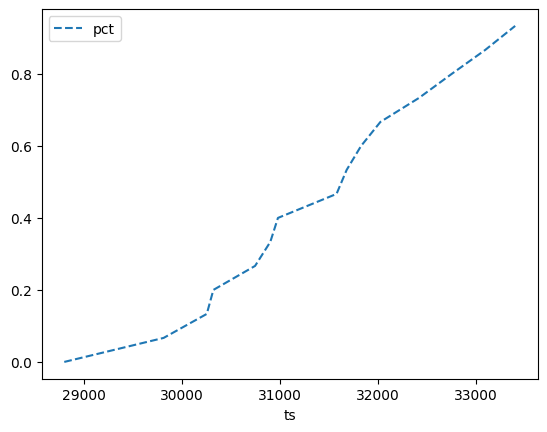

In [245]:
neighborhood_time.query("starting_node_idx == 15").plot(x = 'ts', y = 'pct', style = '--')

In [84]:
cover_time_t = [pd.read_parquet(f) for f in glob.glob(f"cover_time_output//mag_t_neighborhood*.parquet")]
cover_time_t = pd.concat(cover_time_t, ignore_index = True)
c_t = cover_time_t.groupby(
    ['start_time', 'starting_node_idx']
).agg(
    min_ts = ('ts', 'min'),
    max_ts = ('ts', 'max')
).reset_index()
c_t['dt'] = c_t.max_ts - c_t.min_ts - 60 * c_t.start_time.astype(float)
c_t.groupby(
    'start_time'
).dt.mean().reset_index()

,start_time,dt
0,300,50190.535714
1,360,42992.309133
2,420,35790.684685
3,480,28590.713115
4,540,21391.586751


In [91]:
cover_time_t.query("starting_node_idx == 2 and start_time == '300'").sort_values('ts').head(60)

,neighborhood,ts,start_value,start_time,starting_node_idx
123372,BIGORRILHO,18056.0,ignore,300,2
123373,CAMPINA DO SIQUEIRA,18191.0,ignore,300,2
123374,SEMINÁRIO,18586.0,ignore,300,2
123375,SANTA QUITÉRIA,18636.0,ignore,300,2
123376,PORTÃO,18757.0,ignore,300,2
123377,VILA IZABEL,18791.0,ignore,300,2
123378,NOVO MUNDO,19298.0,ignore,300,2
123379,CAPÃO RASO,20126.0,ignore,300,2
123380,XAXIM,20326.0,ignore,300,2
123381,BOQUEIRÃO,20534.0,ignore,300,2


In [70]:
cover_time_vt = [pd.read_parquet(f) for f in glob.glob(f"cover_time_output//mag_vt_neighborhood*.parquet")]
cover_time_vt = pd.concat(cover_time_vt, ignore_index = True)
cover_time_vt.groupby(
    ['start_time', 'neighborhood']
).ts.mean().reset_index().pivot(columns = 'start_time', index = 'neighborhood', values = 'ts').head(50)

start_time,300,360,420,480,540
neighborhood,,,,,
ABRANCHES,80673.422222,79851.494888,81843.261830,82283.803691,82383.262599
AHÚ,86111.633333,82244.464213,82390.671924,82554.540268,82823.891247
ALTO BOQUEIRÃO,72546.055556,79257.709611,78449.138801,80343.662752,80544.108753
ALTO DA GLÓRIA,84697.688889,82012.057260,79889.826498,79363.810403,81283.188329
ALTO DA RUA XV,83978.011111,80032.366053,80307.798107,79427.919463,81241.249337
ATUBA,82371.400000,82605.290909,83100.303191,83881.106061,84166.098266
AUGUSTA,84106.222222,84111.567568,82263.841270,83104.854545,84149.961538
BACACHERI,83635.544444,81373.012270,79872.782334,80472.538591,81092.432361
BAIRRO ALTO,81043.604938,81648.973451,80727.489112,80907.242315,81143.204420
